In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[15:26]) == "AOI_3_Paris"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1071.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1847.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img1822.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img280.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/RGB-PanSharpen_AOI_3_Paris_img202.tif')]

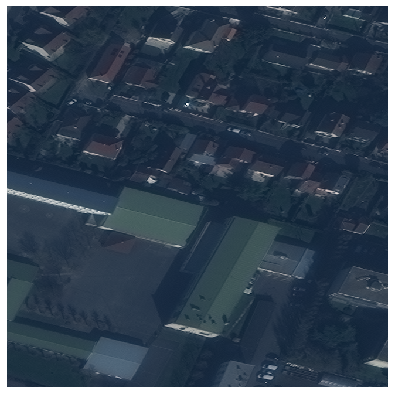

In [6]:
# fig, axs = plt.subplots(1,2,figsize=(6,6))
# open_image(fname[15]).apply_tfms([brightness(change=0.5, p=1)]).show(ax=1)
# # img.show(ax=1)
# open_image(fname[17]).apply_tfms([brightness(change=0.75, p=1), contrast(scale=(1, 1.5), p=1.)]).show(ax = 2)

img = open_image(fname[17])
img.show(figsize=(7,7))

In [7]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Paris_C_buildings.csv")

In [8]:
paris_df = pd.read_csv(path/'Paris_C_buildings.csv')
paris_df = paris_df.drop(columns = 'Unnamed: 0')
paris_df.head()

,Images
0,Images/RGB-PanSharpen_AOI_3_Paris_img1822.tif
1,Images/RGB-PanSharpen_AOI_3_Paris_img280.tif
2,Images/RGB-PanSharpen_AOI_3_Paris_img202.tif
3,Images/RGB-PanSharpen_AOI_3_Paris_img185.tif
4,Images/RGB-PanSharpen_AOI_3_Paris_img748.tif


In [9]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [10]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [11]:
len(paris_df)

633

In [12]:
codes = [0,'building']
random.seed(29)
src = (SegmentationItemList.from_df(paris_df, path).
      split_by_rand_pct(.08).
      label_from_func(get_y_fn, classes=codes))

In [15]:
bs = 32
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 10, max_zoom=1.2, max_lighting = 0.5, max_warp=None,
                                    xtra_tfms = [brightness(change=0.75, p=1), contrast(scale=(1, 1.75), p=1.)]),
                      size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

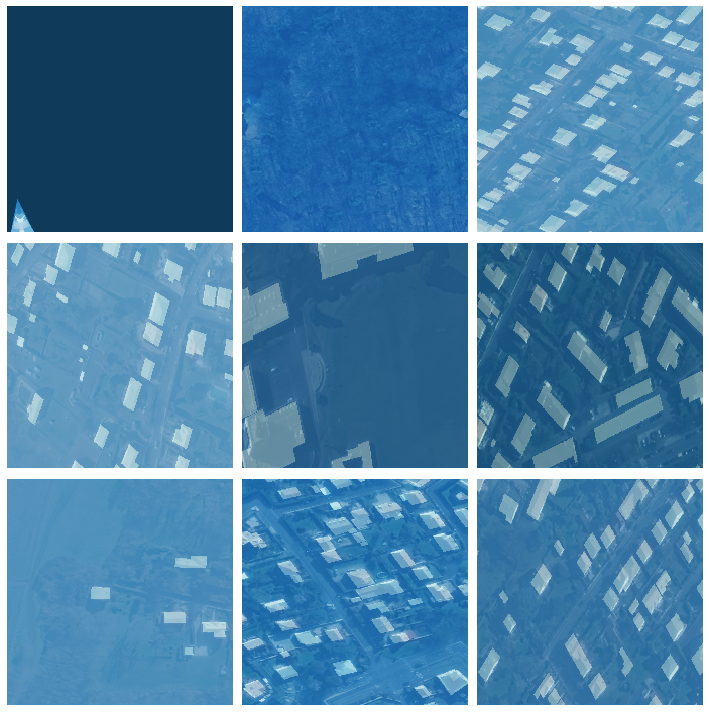

In [16]:
data.show_batch(3, figsize=(10,10))

In [20]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight, 
                     self_attention = True).to_fp16()
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


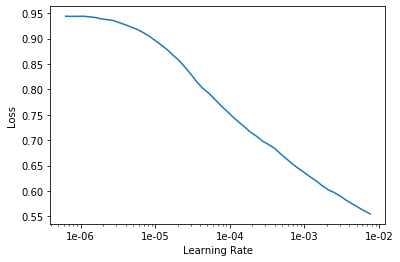

In [21]:
learn.lr_find()
learn.recorder.plot() 

In [22]:
learn.fit_one_cycle(10, slice(5e-4))

epoch,train_loss,valid_loss,dice,time
0,0.548955,0.415773,0.001865,00:09
1,0.437421,0.313644,0.039557,00:09
2,0.367593,0.304132,0.200969,00:09
3,0.318652,0.245557,0.401757,00:09
4,0.285840,0.239295,0.295099,00:09
5,0.260248,0.230438,0.355312,00:09
6,0.247592,0.230235,0.369079,00:09
7,0.233165,0.214040,0.419927,00:09
8,0.222311,0.215319,0.416456,00:09
9,0.214416,0.216839,0.409033,00:09


In [23]:
save_model(learn, 'Paris_DAC', 'F', 'smol', 1)

# Start Recording

In [13]:
import wandb
from wandb.fastai import WandbCallback

In [25]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [26]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Paris.ipynb"

In [27]:
wandb.init(project="spacenet_buildings", name = 'Paris_DAC_smol')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/50w4wepp

In [28]:
load_model(learn, 'Paris_DAC', 'F', 'smol', 1)

In [29]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.199473,0.213290,0.449236,00:09
1,0.200316,0.229914,0.345313,00:09
2,0.199006,0.219437,0.493107,00:09
3,0.201689,0.216854,0.380071,00:09
4,0.200427,0.205595,0.498422,00:09
5,0.199317,0.209159,0.435735,00:09
6,0.195973,0.194954,0.508306,00:09
7,0.191917,0.195409,0.483246,00:09
8,0.188083,0.187419,0.533406,00:09
9,0.183179,0.187185,0.510839,00:09


Better model found at epoch 0 with valid_loss value: 0.21329006552696228.
Better model found at epoch 4 with valid_loss value: 0.20559455454349518.
Better model found at epoch 6 with valid_loss value: 0.19495435059070587.
Better model found at epoch 8 with valid_loss value: 0.18741919100284576.
Better model found at epoch 9 with valid_loss value: 0.1871848702430725.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_202048-50w4wepp/bestmodel.pth


In [30]:
save_model(learn, 'Paris_DAC', 'F', 'smol', 2)

In [31]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(10, slice(5e-6, 5e-5), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.171995,0.186388,0.526180,00:09
1,0.171637,0.187254,0.529008,00:09
2,0.172541,0.189125,0.534415,00:09
3,0.171908,0.186612,0.531472,00:09
4,0.171210,0.186359,0.533140,00:09
5,0.171298,0.184814,0.532720,00:09
6,0.171235,0.191721,0.498422,00:09
7,0.170285,0.181664,0.544140,00:09
8,0.169432,0.182535,0.544400,00:09
9,0.168233,0.182736,0.539527,00:09


Better model found at epoch 0 with valid_loss value: 0.186388298869133.
Better model found at epoch 4 with valid_loss value: 0.1863589882850647.
Better model found at epoch 5 with valid_loss value: 0.18481439352035522.
Better model found at epoch 7 with valid_loss value: 0.18166442215442657.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_202048-50w4wepp/bestmodel.pth


In [33]:
save_model(learn, 'Paris_DAC', 'UF', 'smol', 1)

In [34]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.166834,0.181985,0.541098,00:10
1,0.165937,0.182585,0.535287,00:09
2,0.166883,0.182666,0.539432,00:09
3,0.166184,0.184150,0.534852,00:09
4,0.166953,0.184473,0.538990,00:09
5,0.167092,0.183841,0.535595,00:09
6,0.167133,0.181777,0.535258,00:09
7,0.166739,0.183352,0.534708,00:09
8,0.166448,0.182638,0.536531,00:09
9,0.166537,0.183032,0.535277,00:09


Better model found at epoch 0 with valid_loss value: 0.18198451399803162.
Better model found at epoch 6 with valid_loss value: 0.1817767322063446.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_202048-50w4wepp/bestmodel.pth


In [35]:
save_model(learn, 'Paris_DAC', 'UF', 'smol', 2)

## GO BIG

In [14]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 10, max_zoom=1.2, max_lighting = 0.5, 
                                    xtra_tfms = [brightness(change=0.75, p=1), contrast(scale=(1, 1.75), p=1.)]),
                      size = size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [15]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                     self_attention = True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [16]:
load_model(learn, 'Paris_DAC', 'UF', 'smol', 2)

In [16]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Paris.ipynb"

In [17]:
wandb.init(project="spacenet_buildings", name = 'Paris_Big_SA_DAC')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/g51pangg

In [19]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.185014,0.163736,0.541741,00:35
1,0.180387,0.160154,0.578184,00:20
2,0.173043,0.155104,0.550809,00:20
3,0.168190,0.151093,0.555853,00:20
4,0.173527,0.155211,0.547803,00:20
5,0.168487,0.187596,0.432102,00:20
6,0.166533,0.149803,0.567415,00:20
7,0.161127,0.148021,0.558409,00:20
8,0.155210,0.141762,0.594769,00:20
9,0.150728,0.139322,0.600312,00:20


Better model found at epoch 0 with valid_loss value: 0.16373582184314728.
Better model found at epoch 1 with valid_loss value: 0.1601538211107254.
Better model found at epoch 2 with valid_loss value: 0.15510393679141998.
Better model found at epoch 3 with valid_loss value: 0.1510925590991974.
Better model found at epoch 6 with valid_loss value: 0.14980283379554749.
Better model found at epoch 7 with valid_loss value: 0.14802096784114838.
Better model found at epoch 8 with valid_loss value: 0.1417616754770279.
Better model found at epoch 9 with valid_loss value: 0.13932238519191742.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [20]:
save_model(learn, 'Paris_DAC', 'F', 'big', 1)

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.5)

epoch,train_loss,valid_loss,dice,time
0,0.144433,0.138744,0.608525,00:21
1,0.142582,0.138369,0.605622,00:21
2,0.143187,0.135820,0.605283,00:20
3,0.143470,0.140695,0.579939,00:20
4,0.142156,0.136996,0.610080,00:21
5,0.142075,0.139964,0.631800,00:21
6,0.142858,0.136466,0.619598,00:21
7,0.140391,0.133922,0.621609,00:21
8,0.140422,0.134070,0.627547,00:21
9,0.138562,0.131622,0.625173,00:21


Better model found at epoch 0 with valid_loss value: 0.13874366879463196.
Better model found at epoch 1 with valid_loss value: 0.13836923241615295.
Better model found at epoch 2 with valid_loss value: 0.13582006096839905.
Better model found at epoch 7 with valid_loss value: 0.1339217573404312.
Better model found at epoch 9 with valid_loss value: 0.1316215842962265.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [23]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 1)

In [24]:
learn.fit_one_cycle(7, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.136523,0.132351,0.624724,00:21
1,0.136829,0.132789,0.629176,00:21
2,0.139087,0.139166,0.632515,00:21
3,0.139008,0.135361,0.628101,00:21
4,0.138104,0.134084,0.617596,00:21
5,0.137592,0.131312,0.629833,00:20
6,0.135601,0.130050,0.627883,00:21


Better model found at epoch 0 with valid_loss value: 0.132350891828537.
Better model found at epoch 5 with valid_loss value: 0.13131219148635864.
Better model found at epoch 6 with valid_loss value: 0.1300497055053711.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [25]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 2)

In [26]:
learn.fit_one_cycle(10, slice(5e-6, 5e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.133201,0.130298,0.627286,00:21
1,0.135975,0.130221,0.631779,00:21
2,0.134456,0.131026,0.623881,00:21
3,0.132752,0.131207,0.632546,00:21
4,0.133221,0.133616,0.619818,00:20
5,0.133538,0.129341,0.632223,00:21
6,0.133314,0.129088,0.636252,00:21
7,0.131903,0.128595,0.636756,00:21
8,0.131262,0.127801,0.636755,00:21
9,0.131097,0.128377,0.631301,00:21


Better model found at epoch 0 with valid_loss value: 0.13029754161834717.
Better model found at epoch 1 with valid_loss value: 0.13022050261497498.
Better model found at epoch 5 with valid_loss value: 0.12934133410453796.
Better model found at epoch 6 with valid_loss value: 0.1290881335735321.
Better model found at epoch 7 with valid_loss value: 0.1285954713821411.
Better model found at epoch 8 with valid_loss value: 0.1278008222579956.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [27]:
learn.fit_one_cycle(5, slice(5e-6, 5e-5), pct_start = 0.6)

epoch,train_loss,valid_loss,dice,time
0,0.128469,0.128352,0.634526,00:21
1,0.130619,0.131737,0.617015,00:20
2,0.131596,0.132927,0.609190,00:21
3,0.130714,0.128931,0.629194,00:21
4,0.129800,0.127790,0.630398,00:21


Better model found at epoch 0 with valid_loss value: 0.1283520609140396.
Better model found at epoch 4 with valid_loss value: 0.12779030203819275.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [28]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 3)

In [29]:
learn.fit_one_cycle(8, slice(1e-6, 1e-5), pct_start = 0.5)

epoch,train_loss,valid_loss,dice,time
0,0.130325,0.127696,0.632375,00:21
1,0.129258,0.128158,0.633413,00:21
2,0.128988,0.128594,0.627652,00:21
3,0.129722,0.127613,0.635343,00:21
4,0.129053,0.127545,0.635590,00:21
5,0.129367,0.127253,0.637599,00:21
6,0.128343,0.127508,0.633822,00:21
7,0.127918,0.126647,0.636774,00:21


Better model found at epoch 0 with valid_loss value: 0.12769554555416107.


wandb: Wandb version 0.8.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Better model found at epoch 3 with valid_loss value: 0.12761332094669342.
Better model found at epoch 4 with valid_loss value: 0.12754501402378082.
Better model found at epoch 5 with valid_loss value: 0.1272526979446411.
Better model found at epoch 7 with valid_loss value: 0.12664693593978882.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_203124-q0n331u0/bestmodel.pth


In [30]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 4)

In [18]:
load_model(learn, 'Paris_DAC', 'UF', 'big', 4)

In [19]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.5)

epoch,train_loss,valid_loss,dice,time
0,0.129791,0.113309,0.658634,00:35
1,0.128474,0.113251,0.658426,00:20
2,0.130163,0.113837,0.659250,00:20
3,0.129536,0.113404,0.655430,00:20
4,0.129891,0.113529,0.658722,00:20
5,0.128201,0.113418,0.656338,00:20
6,0.129501,0.113612,0.659859,00:20
7,0.129827,0.113389,0.660107,00:20
8,0.129446,0.113331,0.661830,00:20
9,0.129070,0.113444,0.657718,00:20


Better model found at epoch 0 with valid_loss value: 0.11330927163362503.
Better model found at epoch 1 with valid_loss value: 0.11325124651193619.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_213240-g51pangg/bestmodel.pth


In [20]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 5)

In [21]:
learn.fit_one_cycle(10, slice(5e-6, 5e-5), pct_start = 0.5)

epoch,train_loss,valid_loss,dice,time
0,0.130603,0.113475,0.658752,00:20
1,0.130764,0.113319,0.657612,00:21
2,0.130028,0.113604,0.653269,00:20
3,0.130331,0.114874,0.644953,00:20
4,0.132141,0.112863,0.660191,00:20
5,0.130794,0.115199,0.661133,00:20
6,0.130313,0.113816,0.663846,00:20
7,0.129373,0.114874,0.664865,00:20
8,0.128986,0.113129,0.661601,00:20
9,0.127764,0.112992,0.660044,00:20


Better model found at epoch 0 with valid_loss value: 0.11347484588623047.
Better model found at epoch 1 with valid_loss value: 0.11331894248723984.
Better model found at epoch 4 with valid_loss value: 0.11286292225122452.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200124_213240-g51pangg/bestmodel.pth


In [22]:
save_model(learn, 'Paris_DAC', 'UF', 'big', 5)